In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.0 MB/s eta 0:00:00


In [4]:
pip install pydot

In [6]:
from textblob import Word
import nltk
# from google.colab import drive

# Mount Google Drive
# drive.mount('/content/drive')

# Set NLTK data path to a directory in Google Drive
nltk.data.path.append('/content/drive/My Drive/DL/nltk_data')

# Download 'wordnet'
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
# Libraray for Data Manipulation
import numpy as np
import pandas as pd

# Libraray for Data Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white",font_scale=1.5)
sns.set(rc={"axes.facecolor":"#FFFAF0","figure.facecolor":"#FFFAF0"})
sns.set_context("poster",font_scale = .7)

# Library for preprocessing
import contractions
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
import spacy
import math
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import Parallel, delayed
import re,string,unicodedata
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from scipy.sparse import lil_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk import pos_tag

# Library for model building
from tensorflow.keras.regularizers import l2
import tensorflow
import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential,Model
#from attention import BahdanauAttention
from keras.layers import SimpleRNN,LSTM,GRU, Embedding, Dense, SpatialDropout1D, Dropout, BatchNormalization, Bidirectional, Attention, Input, Concatenate
from sklearn.metrics import accuracy_score
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.optimizers import Adam

#Library to overcome Warnings
import warnings
warnings.filterwarnings('ignore')

In [8]:
save_dir = '/content/drive/MyDrive/DL/'

# Load the dataset
train_df = pd.read_csv(save_dir + 'train.csv')
test_df = pd.read_csv(save_dir + 'test.csv')

In [9]:
train_df.sample(5)

,id,dialogue,summary
1419,13716010,Jake: <file_photo>\r\nJake: what do lladies th...,Jake is wondering if it is enough for their ki...
8332,13821733,"Sam: Hello!\r\nLara: Hi, is Lucas still alive?...",Lucas's dating Sarah again.
6426,13682179,Jake: red or white?\r\nNatalie: what do u mean...,Jake will get white wine for his dinner with N...
880,13818973,Jason: Although he is not a good striker with ...,"He deserves respect from Arsenal fans, because..."
11746,13862761,Missy: hey\nMissy: i was just thinking\nClara:...,Clara reminds Missy that the name of the song ...


In [10]:
test_df.sample(5)

,id,dialogue,summary
541,13828550,Eric: Yo yo\r\nDan: Yo man\r\nEric: Have you w...,Dan has watched Punisher season 2 and Eric fin...
212,13829937,Nathan: <file_video>\r\nAaron: OMG!!! \r\nAaro...,Nathan and Aaron are discussing a video which ...
10,13680771,Wanda: Let's make a party!\r\nGina: Why?\r\nWa...,Wanda wants to throw a party. She asks Gina to...
257,13715786,Jamie: What do you think about doing those pre...,"Jamie, Marlo, Jimmy and Alex's teacher require..."
91,13682034,Danna: How's your Saturday?\r\nReed: It was al...,Danna has a boring weekend and is watching TV....


In [11]:
print("train_df shape: ",train_df.shape)
print("test_df shape: ",test_df.shape)

train_df shape:  (14732, 3)
test_df shape:  (819, 3)


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14732 entries, 0 to 14731
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        14732 non-null  object
 1   dialogue  14731 non-null  object
 2   summary   14732 non-null  object
dtypes: object(3)
memory usage: 345.4+ KB


In [13]:
print("Duplicates in Dataset: ",train_df.duplicated().sum())

Duplicates in Dataset:  0


In [14]:
missing_data = train_df.isnull().sum().to_frame().rename(columns={0:"Total No. of Missing Values"})
missing_data["% of Missing Values"] = round((missing_data["Total No. of Missing Values"]/len(train_df))*100,2)
missing_data

,Total No. of Missing Values,% of Missing Values
id,0,0.00
dialogue,1,0.01
summary,0,0.00


In [15]:
round(train_df.describe().T,2)

,count,unique,top,freq
id,14732,14732,13729017,1
dialogue,14731,14264,"Jimmy: Hey, guess what? My car's completely ka...",4
summary,14732,14730,Seth's pet Oreo that he got when he was 10 is ...,2


In [16]:
col = 'id'
train_df.drop(col,axis = 1,inplace = True)
test_df.drop(col,axis = 1,inplace = True)

In [17]:
train_df.dropna(inplace = True)

In [18]:
train_df['dialogue'] = train_df['dialogue'].str.lower()
train_df['summary'] = train_df['summary'].str.lower()
test_df['dialogue'] = test_df['dialogue'].str.lower()
test_df['summary'] = test_df['summary'].str.lower()

In [19]:
import re
def remove_html_tags(text):
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern,'',text)
    return text


In [20]:
train_df['dialogue'] = train_df['dialogue'].apply(remove_html_tags)
train_df['summary'] = train_df['summary'].apply(remove_html_tags)
test_df['dialogue'] = test_df['dialogue'].apply(remove_html_tags)
test_df['summary'] = test_df['summary'].apply(remove_html_tags)

In [21]:
def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'',text)

train_df['dialogue'] = train_df['dialogue'].apply(remove_url)
train_df['summary'] = train_df['summary'].apply(remove_url)
test_df['dialogue'] = test_df['dialogue'].apply(remove_url)
test_df['summary'] = test_df['summary'].apply(remove_url)

In [22]:
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laughter",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "LOL": "Laughing out loud",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don’t care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "IDC": "I don’t care",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "LMAO": "Laughing my a** off",
    "BFF": "Best friends forever",
    "CSL": "Can’t stop laughing",
}

In [23]:
def chat_conversion(text):
    new_text=[]
    for w in text.split():
        if w.upper() in chat_words:
            new_text.append(chat_words[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

In [24]:
train_df['dialogue'] = train_df['dialogue'].apply(chat_conversion)
train_df['summary'] = train_df['summary'].apply(chat_conversion)
test_df['dialogue'] = test_df['dialogue'].apply(chat_conversion)
test_df['summary'] = test_df['summary'].apply(chat_conversion)

In [25]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [26]:
train_df['dialogue'] = train_df['dialogue'].apply(remove_emoji)
train_df['summary'] = train_df['summary'].apply(remove_emoji)
test_df['dialogue'] = test_df['dialogue'].apply(remove_emoji)
test_df['summary'] = test_df['summary'].apply(remove_emoji)

In [27]:
def expand_contractions(text):
    expanded_text = contractions.fix(text)
    return expanded_text

train_df['dialogue'] = train_df['dialogue'].apply(expand_contractions)
train_df['summary'] = train_df['summary'].apply(expand_contractions)
test_df['dialogue'] = test_df['dialogue'].apply(expand_contractions)
test_df['summary'] = test_df['summary'].apply(expand_contractions)

In [28]:
train_df['summary'] = ['<start> ' + sentence + ' <end>' for sentence in train_df['summary']]
test_df['summary'] = ['<start> ' + sentence + ' <end>' for sentence in test_df['summary']]

In [29]:
tok = Tokenizer()
tok.fit_on_texts(train_df['dialogue']+train_df['summary'])

In [30]:
len(tok.word_index)

33259

In [31]:
tok.document_count

14731

In [32]:
# Convert training dialogues and summaries to sequences
train_df['dialogue'] = tok.texts_to_sequences(train_df['dialogue'])
train_df['summary'] = tok.texts_to_sequences(train_df['summary'])

# Convert test dialogues and summaries to sequences (without fitting)
test_df['dialogue'] = tok.texts_to_sequences(test_df['dialogue'])
test_df['summary'] = tok.texts_to_sequences(test_df['summary'])

In [33]:
train_df

,dialogue,summary
0,"[423, 1, 3359, 1528, 15, 2, 71, 52, 584, 70, 4...","[16, 423, 3359, 1528, 6, 12, 211, 584, 52, 98,..."
1,"[318, 144, 18, 2, 5396, 11, 10, 39, 2944, 604,...","[16, 318, 6, 1588, 18, 5396, 11, 11934, 10, 39..."
2,"[225, 116, 26, 7, 60, 356, 217, 1440, 3, 24, 8...","[16, 356, 235, 174, 4, 16211, 13671, 1959, 118..."
3,"[1001, 410, 1, 61, 1, 21, 10, 21537, 29, 831, ...","[16, 1001, 556, 38, 7, 10, 132, 29, 831, 410, ..."
4,"[192, 113, 9658, 491, 167, 109, 192, 1, 15, 8,...","[16, 192, 7, 2350, 110, 38, 9658, 491, 2300, 3..."
...,...,...
14727,"[4686, 2, 18, 25, 20, 141, 2, 235, 32, 845, 13...","[16, 4686, 7, 512, 3, 64, 1386, 3, 1281, 76, 3..."
14728,"[1076, 137, 1076, 137, 1076, 113, 882, 50, 18,...","[16, 1076, 7, 27, 96, 33, 765, 323, 341, 6, 32..."
14729,"[112, 432, 146, 52, 217, 527, 2850, 12, 5972, ...","[16, 2850, 7, 46, 3, 5972, 8896, 177, 1983, 6,..."
14730,"[597, 631, 2969, 50, 18, 2, 214, 597, 4, 656, ...","[16, 2969, 101, 8, 129, 9, 3, 4, 656, 29, 4, 3..."


In [34]:
def calculate_max_sequence_length(train_summary,train_dialogue,test_summary,test_dialogue):
    max_length_1 = max(max(len(seq) for seq in train_dialogue), max(len(seq) for seq in train_summary))
    max_length_2 = max(max(len(seq) for seq in test_dialogue), max(len(seq) for seq in test_summary))
    max_length_combined = max(max_length_1,max_length_2)
    return max_length_combined

max_length_combined = calculate_max_sequence_length(train_df['dialogue'],train_df['summary'],test_df['dialogue'],test_df['summary'])
max_length_combined

819

In [35]:
for num in train_df['dialogue'][0]:
    print(num, end=' ')

423 1 3359 1528 15 2 71 52 584 70 423 54 211 2 98 

In [36]:
# Print corresponding words horizontally
for num in train_df['dialogue'][0]:
    word = tok.index_word.get(num, 'UNK')
    print(word, end=' ')

amanda i baked cookies do you want some jerry sure amanda ill bring you tomorrow 

In [37]:
for num in train_df['summary'][0]:
    word = tok.index_word.get(num)
    print(word,end = " ")

start amanda baked cookies and will bring jerry some tomorrow end 

In [38]:
x_train = pad_sequences(train_df['dialogue'],maxlen = max_length_combined,padding = 'post')
y_train = pad_sequences(train_df['summary'],maxlen = max_length_combined,padding = 'post')
x_test = pad_sequences(test_df['dialogue'],maxlen = max_length_combined,padding = 'post')
y_test = pad_sequences(test_df['summary'],maxlen = max_length_combined,padding = 'post')

In [39]:
x_train

array([[ 423,    1, 3359, ...,    0,    0,    0],
       [ 318,  144,   18, ...,    0,    0,    0],
       [ 225,  116,   26, ...,    0,    0,    0],
       ...,
       [ 112,  432,  146, ...,    0,    0,    0],
       [ 597,  631, 2969, ...,    0,    0,    0],
       [1586,   18,    2, ...,    0,    0,    0]], dtype=int32)

In [40]:
y_train

array([[  16,  423, 3359, ...,    0,    0,    0],
       [  16,  318,    6, ...,    0,    0,    0],
       [  16,  356,  235, ...,    0,    0,    0],
       ...,
       [  16, 2850,    7, ...,    0,    0,    0],
       [  16, 2969,  101, ...,    0,    0,    0],
       [  16, 1586,    6, ...,    0,    0,    0]], dtype=int32)

In [41]:
# Check the shape of the resulting arrays
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (14731, 819)
Shape of x_test: (819, 819)
Shape of y_train: (14731, 819)
Shape of y_test: (819, 819)


In [42]:
max_length_input = x_train.shape[1]
max_length_output = y_train.shape[1]
input_vocab_size = len(tok.word_index) + 1
output_vocab_size = len(tok.word_index) + 1

# Define Encoder model
encoder_inputs = Input(shape=(max_length_input,))
encoder_embedding = Embedding(input_dim=input_vocab_size, output_dim=260)(encoder_inputs)
encoder_lstm = LSTM(64, return_sequences=True, return_state=True)  # Ensure return_sequences=True
encoder_lstm = LSTM(64, return_sequences=True, return_state=True)  # Ensure return_sequences=True
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Define Decoder model
decoder_inputs = Input(shape=(max_length_output,))
decoder_embedding = Embedding(input_dim=output_vocab_size, output_dim=260)(decoder_inputs)
decoder_lstm = LSTM(64, return_sequences=True, return_state=True)
decoder_lstm = LSTM(64, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Attention Layer
attention = Attention()([decoder_outputs, encoder_outputs])

# Concatenate attention output with decoder outputs
decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention])

# Dense Layer for output prediction
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the full Encoder-Decoder model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 819)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 819)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 819, 260)       │      8,647,600 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 819, 260)       │      8,647,600 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 819, 64),      │         83,200 │ embedding[0][0]        │
│                           │ (None, 64), (None,     │                │                        │
│                           │ 64)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, 819, 64),      │         83,200 │ embedding_1[0][0],     │
│                           │ (None, 64), (None,     │                │ lstm_1[0][1],          │
│                           │ 64)]                   │                │ lstm_1[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 819, 64)        │              0 │ lstm_3[0][0],          │
│                           │                        │                │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 819, 128)       │              0 │ lstm_3[0][0],          │
│                           │                        │                │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 819, 33260)     │      4,290,540 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 21,752,140 (82.98 MB)

 Trainable params: 21,752,140 (82.98 MB)

 Non-trainable params: 0 (0.00 B)

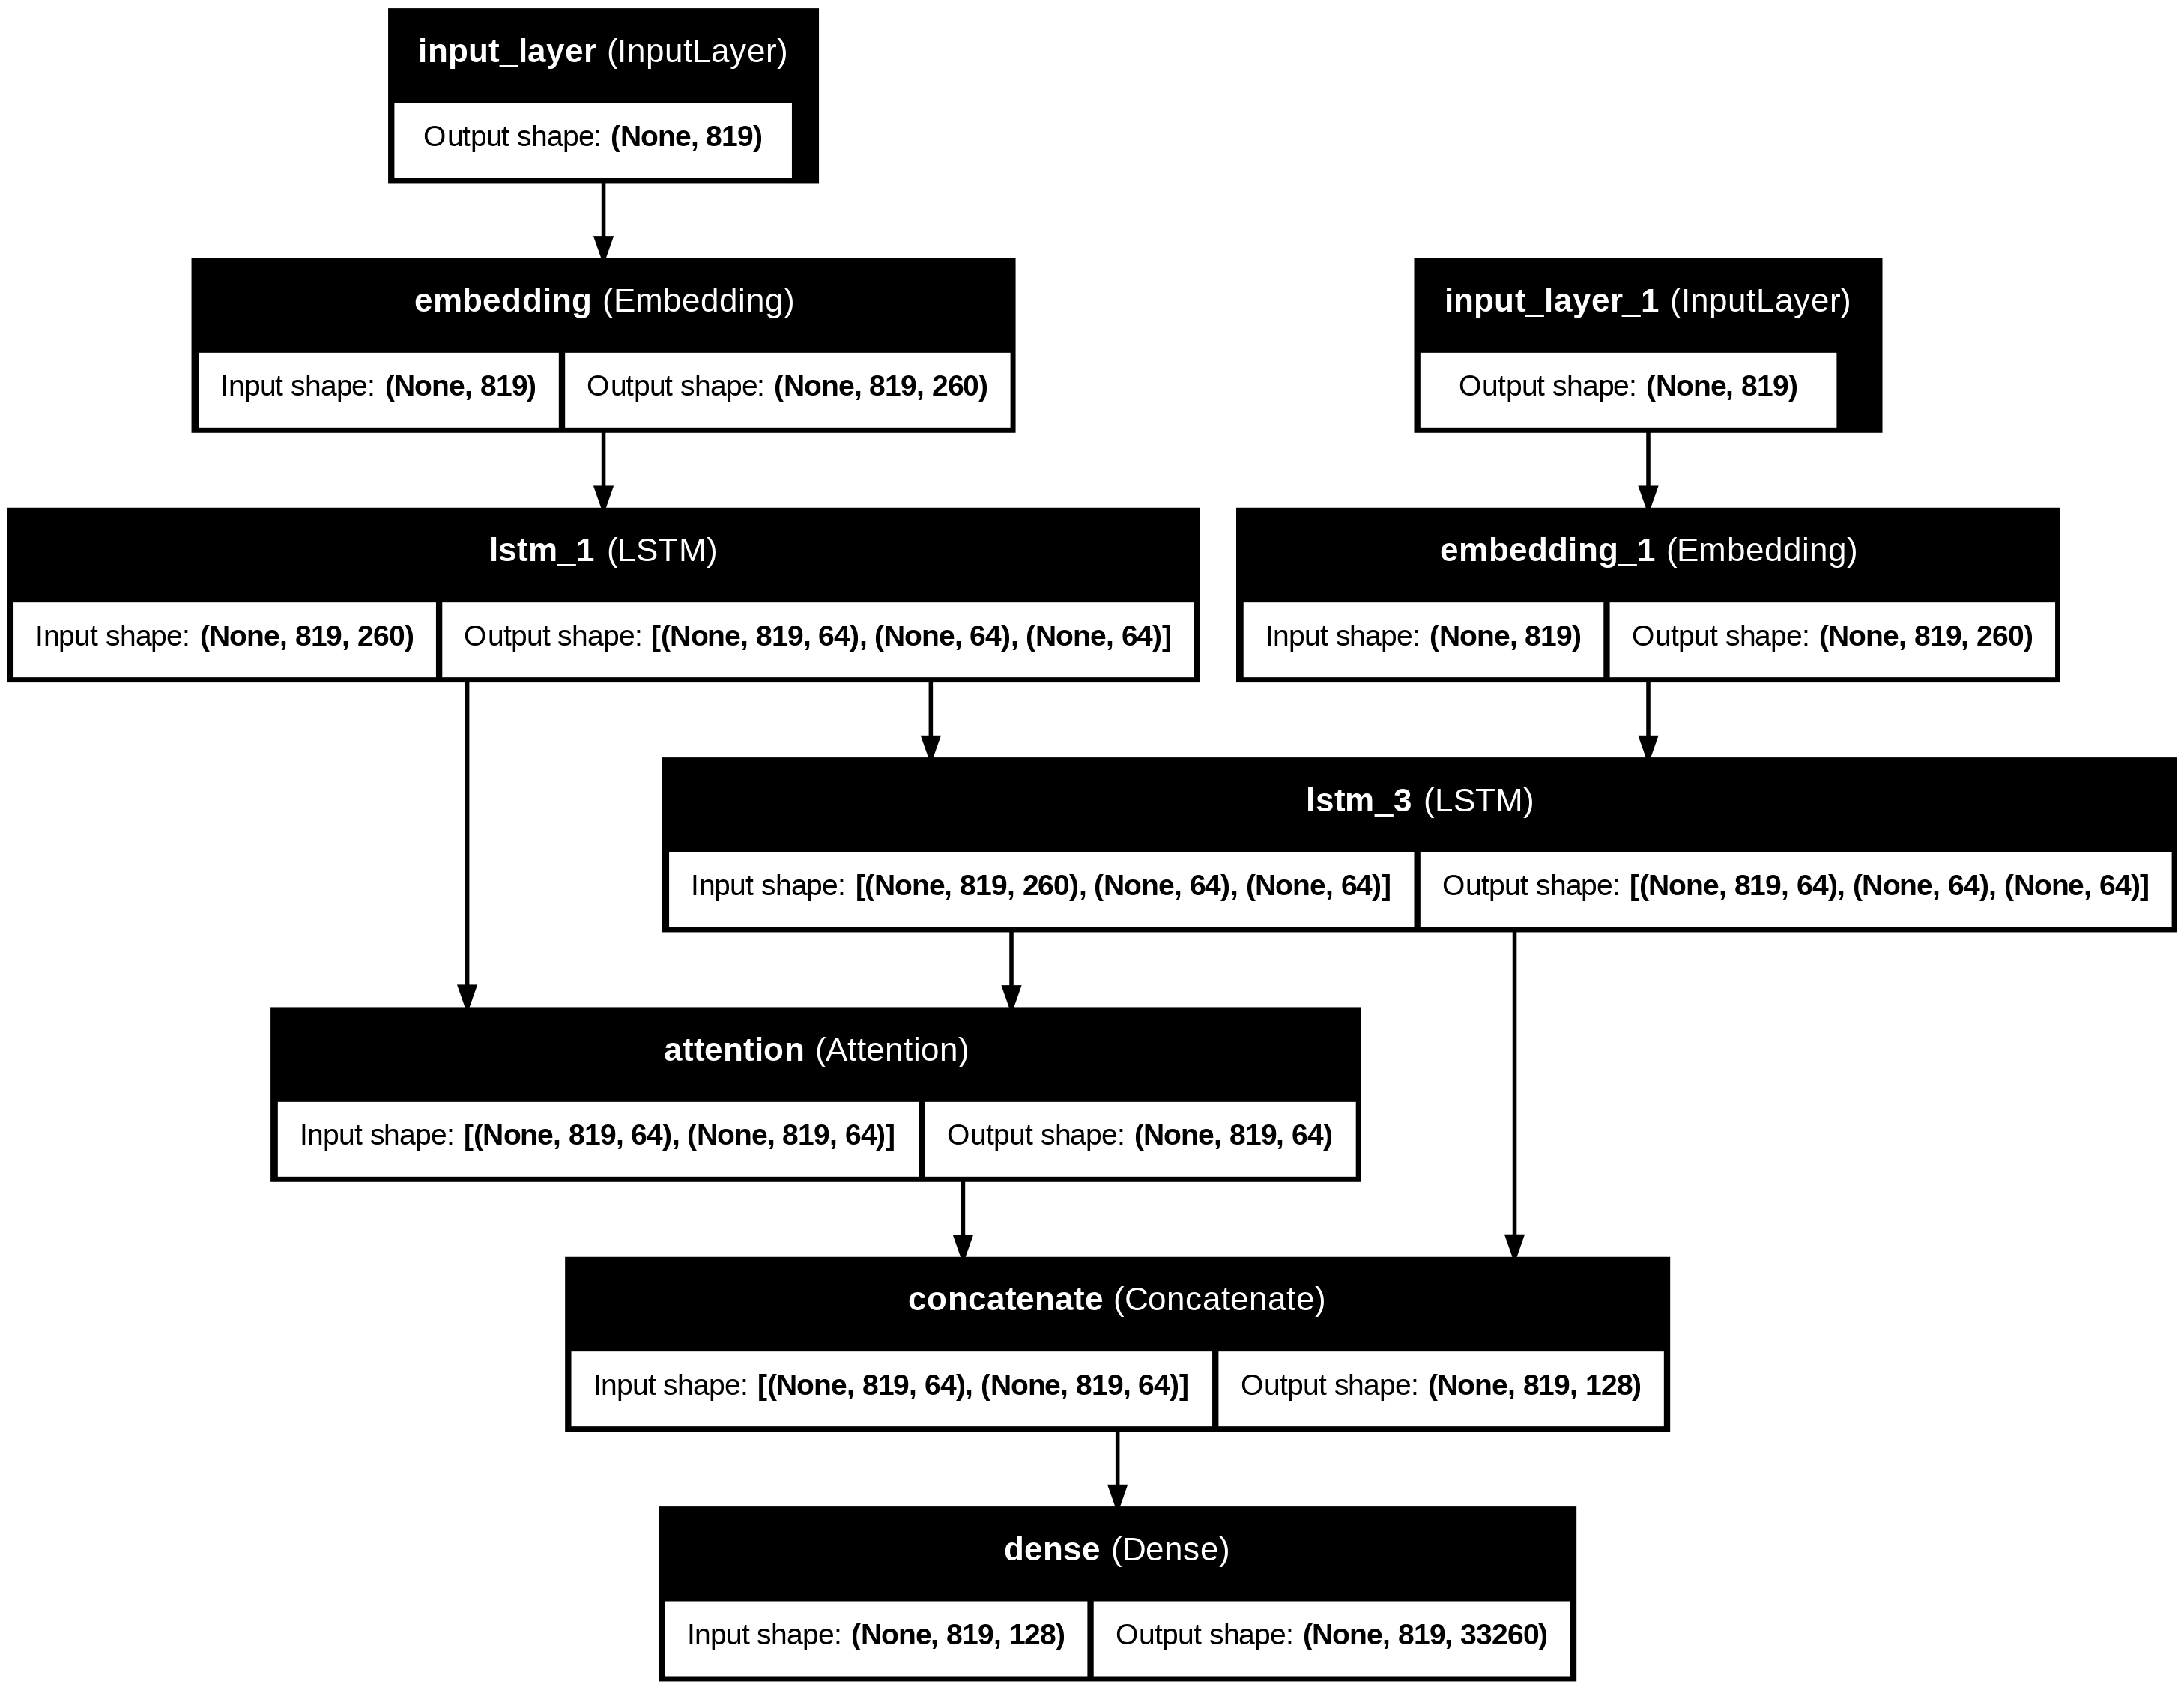

In [43]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
Image('model_plot.png')


In [44]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model_checkpoint.keras', save_best_only=True)  # Updated filepath

# Train the model with callbacks
history = model.fit(
    x=[x_train, y_train],
    y=y_train,
    batch_size=16,
    epochs=5,
    validation_data=([x_test, y_test], y_test),
    callbacks=[early_stopping, model_checkpoint],
)

Epoch 1/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 333s 356ms/step - accuracy: 0.9677 - loss: 1.2796 - val_accuracy: 0.9857 - val_loss: 0.1147
Epoch 2/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 346s 376ms/step - accuracy: 0.9869 - loss: 0.1072 - val_accuracy: 0.9911 - val_loss: 0.0726
Epoch 3/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 384s 378ms/step - accuracy: 0.9912 - loss: 0.0720 - val_accuracy: 0.9937 - val_loss: 0.0531
Epoch 4/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 375s 371ms/step - accuracy: 0.9937 - loss: 0.0533 - val_accuracy: 0.9953 - val_loss: 0.0409
Epoch 5/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 391s 381ms/step - accuracy: 0.9952 - loss: 0.0417 - val_accuracy: 0.9962 - val_loss: 0.0331


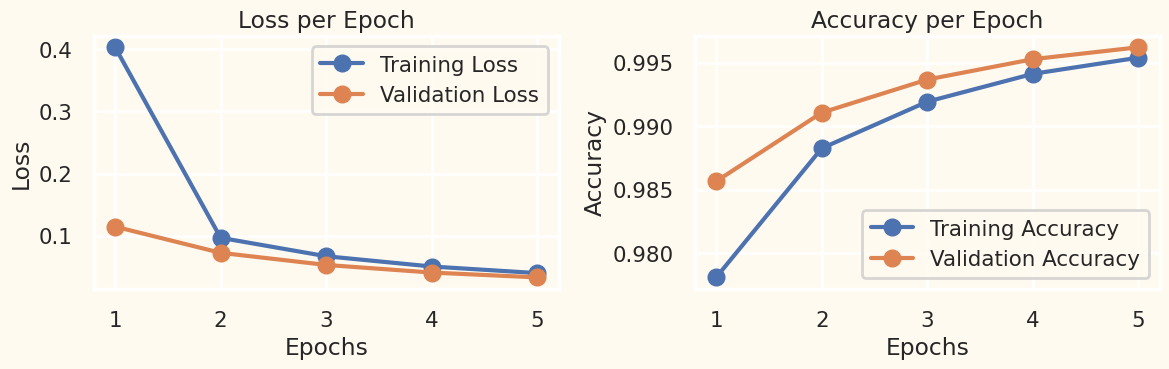

In [45]:
epochs_range = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['loss'], label='Training Loss', marker='o')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs_range)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs_range)
plt.legend()

plt.tight_layout()
plt.show()

In [46]:
from nltk.translate.bleu_score import corpus_bleu

# Reverse token dictionary for summary (assuming you have a tokenizer `tok` for summary)
rev_tok_summary = {idx: word for word, idx in tok.word_index.items()}
rev_tok_dialogue = {idx: word for word, idx in tok.word_index.items()}  # If the dialogue uses the same tokenizer

# Define the batch size
batch_size = 10

# Initialize lists to store predictions and references
predicted_summaries = []
references = []

# Predict on x_test data in batches
for start in range(0, len(x_test), batch_size):
    end = min(start + batch_size, len(x_test))
    x_batch = x_test[start:end]
    y_batch = y_test[start:end]  # Use the corresponding y_test for padding purposes

    # Predict on the batch
    predictions = model.predict([x_batch, y_batch], batch_size=batch_size)

    # Convert predicted tokens to sentences (predicted summaries)
    predicted_tokens_np = np.argmax(predictions, axis=-1)

    for sample in predicted_tokens_np:
        # Convert the predicted tokens into the corresponding words for the summary
        predicted_sentence = ' '.join([rev_tok_summary.get(token, '<unknown>') for token in sample if token != 0 and token not in [tok.word_index.get('start'), tok.word_index.get('end')]])
        predicted_summaries.append(predicted_sentence)

    # Extract the true (actual) summaries for the BLEU score references
    for i in range(len(y_batch)):
        true_summary_sentence = ' '.join([rev_tok_summary.get(token, '<unknown>') for token in y_batch[i] if token != 0 and token not in [tok.word_index.get('start'), tok.word_index.get('end')]])
        references.append([true_summary_sentence.split()])  # BLEU expects list of references for each hypothesis

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

In [47]:
# Evaluate BLEU score for the predicted summaries
bleu_score = corpus_bleu(references, [pred.split() for pred in predicted_summaries])
print(f'BLEU score: {bleu_score:.4f}')

BLEU score: 0.6711


In [54]:
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Reverse token dictionaries
rev_tok = {idx: word for word, idx in tok.word_index.items()}

# Select a subset of test data
num_samples = 20
x_test_subset = x_test[:num_samples]
y_test_padded_subset = y_test[:num_samples]

# Predict
predictions = model.predict([x_test_subset, y_test_padded_subset], batch_size=16)
print('Shape of predictions:', predictions.shape)

# Convert predictions to token indices
predicted_tokens_np = np.argmax(predictions, axis=-1)
print('Shape of predicted_tokens:', predicted_tokens_np.shape)

# Map indices to tokens and remove 'start' and 'end' tokens from predicted summary
predicted_sentences = []
for sample in predicted_tokens_np:
    sentence = ' '.join([rev_tok.get(token, '<unknown>') for token in sample if token != 0 and token not in [tok.word_index.get('start'), tok.word_index.get('end')]])  # Exclude padding, 'start', and 'end' tokens
    predicted_sentences.append(sentence)

# Reverse token dictionary for the dialogue (assuming you have `tok_english` for dialogue tokens)
rev_tok_english = {idx: word for word, idx in tok.word_index.items()}

# Map the dialogue input to sentences
english_sentences = []
for sample in x_test_subset:
    sentence = ' '.join([rev_tok_english.get(token, '<unknown>') for token in sample if token != 0])  # Exclude padding token
    english_sentences.append(sentence)

# Map actual summaries from y_test to sentences
actual_summaries = []
for sample in y_test_padded_subset:
    sentence = ' '.join([rev_tok.get(token, '<unknown>') for token in sample if token != 0 and token not in [tok.word_index.get('start'), tok.word_index.get('end')]])  # Exclude padding, 'start', and 'end' tokens
    actual_summaries.append(sentence)

# Print the dialogue, predicted summary, and actual summary
for idx, (eng_sentence, pred_summary, actual_summary) in enumerate(zip(english_sentences, predicted_sentences, actual_summaries)):
    print(f'Dialogue {idx + 1}: {eng_sentence}')
    print(f'Predicted summary {idx + 1}: {pred_summary}')
    print(f'Actual summary {idx + 1}: {actual_summary}\n')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Shape of predictions: (20, 819, 33260)
Shape of predicted_tokens: (20, 819)
Dialogue 1: hannah hey do you have bettys number amanda let me check hannah filegif amanda sorry cannot find it amanda ask larry amanda he called her last tears in my eyes we were at the park together hannah i do not know him well hannah filegif amanda do not be shy hes very nice hannah if you say so hannah id rather you texted him amanda just text him hannah urgh alright hannah bye amanda bye bye
Predicted summary 1: hannah needs rod number but amanda does not have it she needs to contact larry
Actual summary 1: hannah needs bettys number but amanda does not have it she needs to contact larry

Dialogue 2: eric machine rob that is so great eric i know and shows how americans see russian rob and its really funny eric i know i especially like the train part rob hahaha no one talks to the machine like that eric is this his only standup rob i do not know ill check eric sure ro

In [49]:
# Save the entire model
model.save('/content/drive/MyDrive/DL/encoder_decoder_model_2.h5')
print('Model saved succesfully!!')

Model saved succesfully!!


In [52]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Custom dialogues for testing
custom_dialogues = [# Example input 2
    """Lucia: I need my hair cut.
    Lucia: When can I come? I've got some time on Thursday and Friday.
    Eric: Lucia! My dear!
    Eric: Are you sure? After all, you had your hairstyle done a week ago.
    Eric: What's the matter? Don't you like it?
    Lucia: I like it very much and I regret to lose it.
    Lucia: But I'm changing the job and my hair must be shorter...
    Eric: I see. You'll tell me everything in detail once you're here, in my beauty salon.
    Eric: I suggest Friday at 3 p.m. Is it fine for you?
    Lucia: Sure, perfect.
    Eric: Fantastic, have a nice day then.
    Lucia: Thanks, bye."""
]

# Tokenize the custom dialogues
custom_sequences = tok.texts_to_sequences(custom_dialogues)

# Pad the sequences to the maximum length used during training
max_len_x = x_test.shape[1]  # Assuming x_test is padded to this length
custom_padded_sequences = pad_sequences(custom_sequences, maxlen=max_len_x, padding='post')

# Dummy target sequences (optional, can use zero-padded data if not required for prediction)
# Replace with actual dummy inputs based on your model requirements
max_len_y = y_test.shape[1]  # Assuming y_test is padded to this length
dummy_target = np.zeros((len(custom_dialogues), max_len_y))

# Predict
predictions = model.predict([custom_padded_sequences, dummy_target], batch_size=16)
print('Shape of predictions:', predictions.shape)

# Convert predictions to token indices
predicted_tokens_np = np.argmax(predictions, axis=-1)

# Map indices to tokens and remove 'start' and 'end' tokens from predicted summary
predicted_sentences = []
for sample in predicted_tokens_np:
    sentence = ' '.join([rev_tok.get(token, '<unknown>') for token in sample if token != 0 and token not in [tok.word_index.get('start'), tok.word_index.get('end')]])
    predicted_sentences.append(sentence)

# Map the dialogue input to sentences (for printing)
english_sentences = []
for sample in custom_padded_sequences:
    sentence = ' '.join([rev_tok_english.get(token, '<unknown>') for token in sample if token != 0])
    english_sentences.append(sentence)

# Print the dialogue and predicted summary
for idx, (eng_sentence, pred_summary) in enumerate(zip(custom_dialogues, predicted_sentences)):
    print(f'Custom Dialogue {idx + 1}: {eng_sentence}')
    print(f'Predicted summary {idx + 1}: {pred_summary}\n')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Shape of predictions: (1, 819, 33260)
Custom Dialogue 1: Lucia: I need my hair cut.
    Lucia: When can I come? I've got some time on Thursday and Friday.
    Eric: Lucia! My dear!
    Eric: Are you sure? After all, you had your hairstyle done a week ago.
    Eric: What's the matter? Don't you like it?
    Lucia: I like it very much and I regret to lose it.
    Lucia: But I'm changing the job and my hair must be shorter...
    Eric: I see. You'll tell me everything in detail once you're here, in my beauty salon.
    Eric: I suggest Friday at 3 p.m. Is it fine for you?
    Lucia: Sure, perfect.
    Eric: Fantastic, have a nice day then.
    Lucia: Thanks, bye.
Predicted summary 1: 

